In [6]:
import os
import pydicom
from PIL import Image

# Function to extract numeric part from filename
def extract_number(filename):
    numeric_part = ''.join(filter(str.isdigit, filename))
    return int(numeric_part) if numeric_part else 0  # Return 0 if no numeric characters are found

# Function to convert a DICOM folder to PNG images in a new folder
def dicom_folder_to_png(dicom_folder):
    # Create a new folder for the PNG files
    output_folder = os.path.join(dicom_folder, "PNGS")  # Create a 'PNGS' folder inside the input DICOM folder
    os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

    # List DICOM files in the folder and sort them naturally
    dicom_files = sorted([f for f in os.listdir(dicom_folder)], key=extract_number)

    for idx, dicom_file in enumerate(dicom_files):
        dicom_path = os.path.join(dicom_folder, dicom_file)
        print(f"Converting {dicom_path}...")

        with pydicom.dcmread(dicom_path) as ds:
            # Extract the pixel data from the DICOM file
            pixel_data = ds.pixel_array

            # Normalize pixel values to the range [0, 255]
            normalized_pixel_data = ((pixel_data - pixel_data.min()) / (pixel_data.max() - pixel_data.min()) * 255).astype('uint8')

            # Create a PIL image from the normalized pixel data
            img = Image.fromarray(normalized_pixel_data, mode='L')  # 'L' mode is for grayscale

            # Set the DPI (dots per inch)
            dpi = 512  # You can adjust this value as needed

            # Save the PIL image as a PNG file in the "PNGS" folder with specified settings
            png_file = os.path.join(output_folder, f"{idx + 1:03d}.png")
            img.save(png_file, "PNG", dpi=(dpi, dpi))
            print(f"Saved {png_file}")

# Usage
dicom_folder = "AXIAL"

dicom_folder_to_png(dicom_folder)


Converting AXIAL\PNGS...


PermissionError: [Errno 13] Permission denied: 'AXIAL\\PNGS'

In [12]:
import os
import pydicom
from PIL import Image

# Function to extract numeric part from filename
def extract_number(filename):
    numeric_part = ''.join(filter(str.isdigit, filename))
    return int(numeric_part) if numeric_part else 0  # Return 0 if no numeric characters are found

# Function to convert a DICOM folder to PNG images in a new folder
def dicom_folder_to_png(dicom_folder, output_directory):
    # Create a new folder for the PNG files
    output_folder = os.path.join(output_directory, "PNGS")  # Create a 'PNGS' folder inside the output directory
    os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

    # List DICOM files in the folder and sort them naturally
    dicom_files = sorted([f for f in os.listdir(dicom_folder)], key=extract_number)

    for idx, dicom_file in enumerate(dicom_files):
        dicom_path = os.path.join(dicom_folder, dicom_file)
        print(f"Converting {dicom_path}...")

        with pydicom.dcmread(dicom_path) as ds:
            # Extract the pixel data from the DICOM file
            pixel_data = ds.pixel_array

            # Normalize pixel values to the range [0, 255]
            normalized_pixel_data = ((pixel_data - pixel_data.min()) / (pixel_data.max() - pixel_data.min()) * 255).astype('uint8')

            # Create a PIL image from the normalized pixel data
            img = Image.fromarray(normalized_pixel_data, mode='L')  # 'L' mode is for grayscale

            # Set the DPI (dots per inch)
            dpi = 512  # You can adjust this value as needed

            # Save the PIL image as a PNG file in the "PNGS" folder with specified settings
            png_file = os.path.join(output_folder, f"{idx + 1:03d}.png")
            img.save(png_file, "PNG", dpi=(dpi, dpi))
            print(f"Saved {png_file}")

# Usage
dicom_folder = "AXIAL"
output_directory = "C:\\Users\\seife\\OneDrive\\GoodNotes\\2023 Fall Semester\\ESE 499 Senior Capstone Spine Straightening System"

dicom_folder_to_png(dicom_folder, output_directory)


Converting AXIAL\PNGS...


PermissionError: [Errno 13] Permission denied: 'AXIAL\\PNGS'

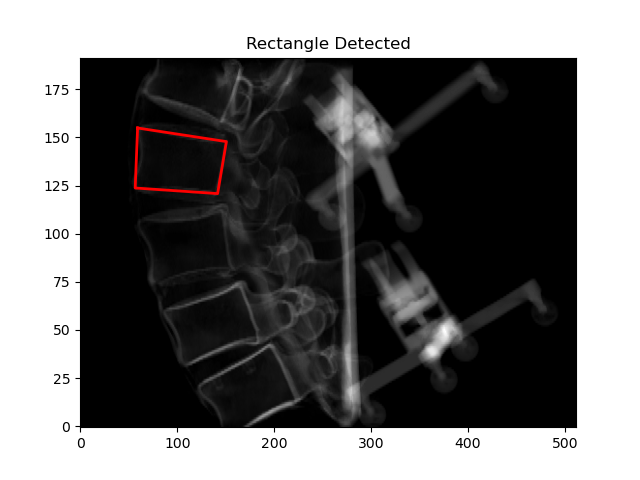

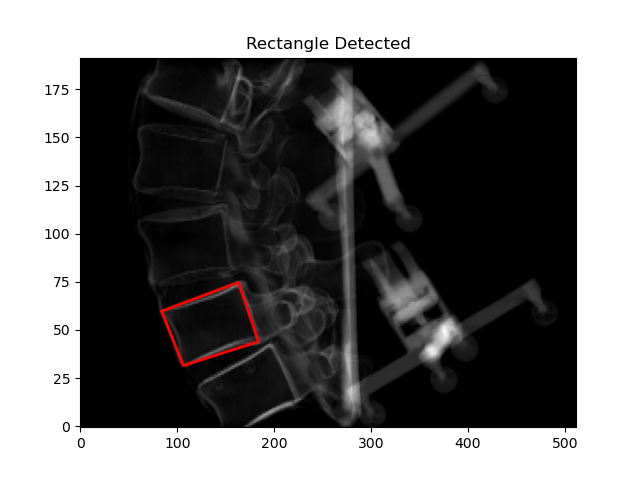

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from IPython.display import Image, display

%matplotlib tk

# Path to your DICOM files
dicom_folder = 'AXIAL'  # Ensure this is the correct path to the DICOM files

# Path to your DICOM files
dicom_folder = 'AXIAL'  # Ensure this is the correct path to the DICOM files

# Function to sort DICOM files
def sort_dicom_files(dicom_files):
    # Create a list of tuples containing the file path and slice location
    slices = []
    for file in dicom_files:
        try:
            dcm = pydicom.dcmread(file, force=True)
            # Check if 'ImagePositionPatient' attribute is present
            if hasattr(dcm, 'ImagePositionPatient'):
                slices.append((file, dcm))
            else:
                print(f"Skipping {file}: 'ImagePositionPatient' attribute not found")
        except Exception as e:
            print(f"Could not read {file}: {e}")
    # Sort based on ImagePositionPatient[2] if available
    slices.sort(key=lambda x: float(x[1].ImagePositionPatient[2]))
    # Return the sorted file paths
    return [x[0] for x in slices]

# Read all DICOM files in the folder and filter for .dcm files
dicom_files = [os.path.join(dicom_folder, file) for file in os.listdir(dicom_folder)]
if not dicom_files:
    raise ValueError(f"No DICOM files found in the folder {dicom_folder}")

dicom_files = sort_dicom_files(dicom_files)
if not dicom_files:
    raise ValueError("No DICOM files with 'ImagePositionPatient' attribute found after sorting.")

# Read the first DICOM file to get metadata
first_dicom = pydicom.dcmread(dicom_files[0])

# Initialize the 3D array to store CT data
CTraw = np.zeros((len(dicom_files), first_dicom.Rows, first_dicom.Columns), dtype=np.int16)

# Read DICOM files and fill the 3D array
for i, dicom_file in enumerate(dicom_files):
    CTraw[i, :, :] = pydicom.dcmread(dicom_file).pixel_array

# Apply threshold mask
mask_value = 1200
CTraw[CTraw < mask_value] = 0

# Change data ordering to match Cartesian coordinates
CT = np.flip(CTraw, axis=0)

# Use XY projection
XYproj = np.sum(CT, axis=2)

# Create and ensure RECTS folder exists
rects_folder = 'RECTS'
if not os.path.exists(rects_folder):
    os.makedirs(rects_folder)

# Function to save rectangles
def save_rectangle(rectangle, rect_id):
    fig, ax = plt.subplots()
    ax.imshow(XYproj, cmap='gray', origin='lower', aspect='auto')
    rectangle.append(rectangle[0])  # Close the rectangle
    rectangle = np.array(rectangle)
    ax.plot(rectangle[:, 0], rectangle[:, 1], 'r-', lw=2)
    ax.set_title('Rectangle Detected')
    rect_filename = os.path.join(rects_folder, f'rectangle_{rect_id}.png')
    fig.savefig(rect_filename)
    plt.close(fig)

# Define lists to store selected points
selected_points = []

# Interactive figure setup
fig, ax = plt.subplots()
ax.imshow(XYproj, cmap='gray', origin='lower', aspect='auto')
plt.title('Click on corner points of rectangles, then press Enter to finish')

def on_click(event):
    if event.inaxes == ax:
        x, y = event.xdata, event.ydata
        selected_points.append((x, y))
        ax.plot(x, y, 'ro', markersize=5)
        plt.draw()

def on_key(event):
    if event.key == 'enter':
        plt.close(fig)
        # Calculate and save each rectangle
        for i in range(0, len(selected_points), 4):
            if i + 3 < len(selected_points):
                save_rectangle(selected_points[i:i+4], i // 4)

        # Display saved rectangles
        for file in sorted(os.listdir(rects_folder)):
            file_path = os.path.join(rects_folder, file)
            display(Image(filename=file_path))

fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from IPython.display import Image, display
from tkinter import Tk, simpledialog, StringVar, OptionMenu
from skimage.transform import resize
import threading

# Switch to Tkinter backend for interactive features
plt.switch_backend("TkAgg")
# Define global variables
current_plane = None
XYproj = None
XZproj = None
YZproj = None
selected_points = []
line_counter = [0]
lines_folder = 'LINES'

def calculate_angle(line1, line2):
    # Convert lines to numpy arrays
    line1 = np.array(line1)
    line2 = np.array(line2)

    # Calculate vectors
    vector1 = line1[1] - line1[0]
    vector2 = line2[1] - line2[0]

    # Calculate dot product
    dot_product = np.dot(vector1, vector2)

    # Calculate magnitudes
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate cosine of the angle
    cos_theta = dot_product / (magnitude1 * magnitude2)

    # Calculate angle in radians
    angle_radians = np.arccos(cos_theta)

    # Convert angle to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

# Function to sort DICOM files
def sort_dicom_files(dicom_files):
    # Create a list of tuples containing the file path and slice location
    slices = []
    for file in dicom_files:
        try:
            dcm = pydicom.dcmread(file, force=True)
            # Check if 'ImagePositionPatient' attribute is present
            if hasattr(dcm, 'ImagePositionPatient'):
                slices.append((file, dcm))
            else:
                print(f"Skipping {file}: 'ImagePositionPatient' attribute not found")
        except Exception as e:
            print(f"Could not read {file}: {e}")
    # Sort based on ImagePositionPatient[2] if available
    slices.sort(key=lambda x: float(x[1].ImagePositionPatient[2]))
    # Return the sorted file paths
    return [x[0] for x in slices]

def save_line(line, line_id, plane):
    line_filename = os.path.join(lines_folder, f'line_{line_id}.txt')
    np.savetxt(line_filename, line)

    fig, ax = plt.subplots()

    if plane == 'XY':
        ax.imshow(XYproj, cmap='gray', origin='lower', aspect='auto')
    elif plane == 'XZ':
        ax.imshow(XZproj, cmap='gray', origin='lower', aspect='auto')
    elif plane == 'YZ':
        ax.imshow(YZproj, cmap='gray', origin='lower', aspect='auto')

    line = np.array(line)
    ax.plot(line[:, 0], line[:, 1], 'r-', lw=2)
    ax.set_title(f'Line Detected ({plane} Plane)')

    fig.savefig(os.path.join(lines_folder, f'line_{line_id}.png'))
    plt.close(fig)

def calculate_and_print_angles():
    global lines_folder
    print(f"Checking files in {lines_folder}")
    for filename in os.listdir(lines_folder):
        print(filename)

    line1_path = os.path.join(lines_folder, 'line_0.txt')
    line2_path = os.path.join(lines_folder, 'line_1.txt')

    if os.path.exists(line1_path) and os.path.exists(line2_path):
        line1 = np.loadtxt(line1_path)
        line2 = np.loadtxt(line2_path)

        angle_degrees = calculate_angle(line1, line2)
        print(f"Angle between the two lines: {angle_degrees:.2f} degrees")
    else:
        print("Files not found. Make sure lines are saved correctly.")

def on_click(event):
    if event.inaxes == ax:
        x, y = event.xdata, event.ydata
        selected_points.append((x, y))
        ax.plot(x, y, 'ro', markersize=5)
        plt.draw()

        # If two points are selected, show popup dialog
        if len(selected_points) == 2:
            root = Tk()
            root.withdraw()
            # Ask the user for the next action
            user_response = simpledialog.askstring("Line Selection", "Place next line or redo points? (next/redo)")
            root.destroy()

            if user_response.lower() == 'next':
                plane = current_plane.get()
                save_line(selected_points, line_counter[0], plane)
                selected_points.clear()
                line_counter[0] += 1

                # Check if two lines have been made
                if line_counter[0] == 2:
                    print("Two lines have been made.")
                    plt.close(fig)
                    # Calculate and save each line
                    for i in range(0, len(selected_points), 2):
                        if i + 1 < len(selected_points):
                            save_line(selected_points[i:i+2], i // 2, plane)
                    # Call the function to calculate and print angles
                    calculate_and_print_angles()
            elif user_response.lower() == 'redo':
                selected_points.pop()
                selected_points.pop()
                ax.cla()
                update_projection()
                plt.title('Click on endpoints of lines you would like to measure (two points per line)')

def get_current_projection():
    if current_plane.get() == 'XY':
        return XYproj
    elif current_plane.get() == 'XZ':
        return XZproj
    elif current_plane.get() == 'YZ':
        return YZproj

def update_projection():
    ax.cla()
    ax.imshow(get_current_projection(), cmap='gray', origin='lower', aspect='auto')
    plt.title('Click on endpoints of lines you would like to measure (two points per line)')
    plt.draw()
   
# Callback function to update the projection when the plane is changed
def on_plane_change(*args):
    update_projection()

# ... (rest of the code remains the same)
# Path to your DICOM files
dicom_folder = 'AXIAL'  # Ensure this is the correct path to the DICOM files

# Read all DICOM files in the folder and filter for .dcm files
dicom_files = [os.path.join(dicom_folder, file) for file in os.listdir(dicom_folder)]
if not dicom_files:
    raise ValueError(f"No DICOM files found in the folder {dicom_folder}")

dicom_files = sort_dicom_files(dicom_files)
if not dicom_files:
    raise ValueError("No DICOM files with 'ImagePositionPatient' attribute found after sorting.")

# Read the first DICOM file to get metadata
first_dicom = pydicom.dcmread(dicom_files[0])

# Initialize the 3D array to store CT data
CTraw = np.zeros((len(dicom_files), first_dicom.Rows, first_dicom.Columns), dtype=np.int16)

# Read DICOM files and fill the 3D array
for i, dicom_file in enumerate(dicom_files):
    CTraw[i, :, :] = pydicom.dcmread(dicom_file).pixel_array

# Apply threshold mask
mask_value = 1200
CTraw[CTraw < mask_value] = 0

# Change data ordering to match Cartesian coordinates
CT = np.flip(CTraw, axis=0)

# Use XY projection
XZproj = np.sum(CT, axis=0)
YZproj = np.sum(CT, axis=1)
XYproj = np.sum(CT, axis=2)

# Create and ensure LINES folder exists
lines_folder = 'LINES'
if not os.path.exists(lines_folder):
    os.makedirs(lines_folder)

# Define lists to store selected points
selected_points = []
line_counter = [0]



# Create the main window
fig, ax = plt.subplots()

# Initialize the plot with default values
ax.imshow(XYproj, cmap='gray', origin='lower', aspect='auto')
plt.title('Click on endpoints of lines you would like to measure (two points per line)')

# Connect the click event to the on_click function
fig.canvas.mpl_connect('button_press_event', on_click)

# Create Tkinter window for plane selection
plane_window = Tk()
plane_window.title("Plane Selection")
plane_options = ['XY', 'XZ', 'YZ']
current_plane = StringVar(plane_window)
current_plane.set('XY')  # Default plane
plane_menu = OptionMenu(plane_window, current_plane, *plane_options)
plane_menu.pack()

# Attach the callback to the plane variable
current_plane.trace('w', on_plane_change)

# Close the plane selection window when the main window is closed
plane_window.protocol("WM_DELETE_WINDOW", plane_window.destroy)

# Function to run Tkinter main loop in a separate thread
def tkinter_mainloop():
    plane_window.mainloop()

# Start the Tkinter main loop in a separate thread
tkinter_thread = threading.Thread(target=tkinter_mainloop)
tkinter_thread.start()

# Display the Matplotlib window
plt.show()


Exception in thread Thread-11 (tkinter_mainloop):
Traceback (most recent call last):
  File "C:\Users\seife\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\seife\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\seife\AppData\Local\Temp\ipykernel_37060\1572975495.py", line 234, in tkinter_mainloop
  File "C:\Users\seife\anaconda3\Lib\tkinter\__init__.py", line 1485, in mainloop
    self.tk.mainloop(n)
RuntimeError: Calling Tcl from different apartment
